Загрузка и предобработка данных

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализация данных
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Добавление размерности для канала (чтобы было 28x28x1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

Кодировщик

In [24]:
from tensorflow.keras import layers, Model

latent_dim = 2  # Размерность латентного пространства

# Входной слой
inputs = layers.Input(shape=(28, 28, 1))

# Кодировщик
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Выходные слои для среднего и логарифма дисперсии
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Репараметризация с помощью лямбда-слоя

In [25]:
from tensorflow.keras import backend as K

# Функция для репараметризации
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Декодер

In [26]:
# Входной слой декодера
decoder_inputs = layers.Input(shape=(latent_dim,))

# Полносвязные и транспонированные свёрточные слои
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model(decoder_inputs, outputs)

Функция потерь

In [34]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        """
        Вычисляет общую потерю VAE.
        inputs: список из [z_mean, z_log_var, original_input, reconstructed_output]
        """
        z_mean, z_log_var, original_input, reconstructed_output = inputs

        # Реконструкционная ошибка (бинарная кросс-энтропия)
        reconstruction_loss = K.binary_crossentropy(
            K.flatten(original_input), K.flatten(reconstructed_output)
        )
        reconstruction_loss = K.sum(reconstruction_loss, axis=-1)  # Суммируем по всем пикселям

        # KL-дивергенция
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        # Общая потеря
        vae_loss = K.mean(reconstruction_loss + kl_loss)

        # Добавляем потерю в слой
        self.add_loss(vae_loss)

        # Возвращаем reconstructed_output (это нужно для совместимости с моделью)
        return reconstructed_output

Сборка VAE

In [35]:
# Выход декодера
reconstructed_outputs = decoder(z)

# Добавляем слой для потерь
loss_output = VAELossLayer()([z_mean, z_log_var, inputs, reconstructed_outputs])

# Модель VAE
vae = Model(inputs, loss_output)

Обучение модели

In [37]:
vae.compile(optimizer='adam')
vae.fit(x_train, 
        epochs=2, 
        batch_size=128, 
        validation_data=(x_test, None)
        )

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - loss: 20247.5527 - val_loss: 19902.9180
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 103ms/step - loss: 19747.3496 - val_loss: 19484.6816


Генерация новых изображений

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

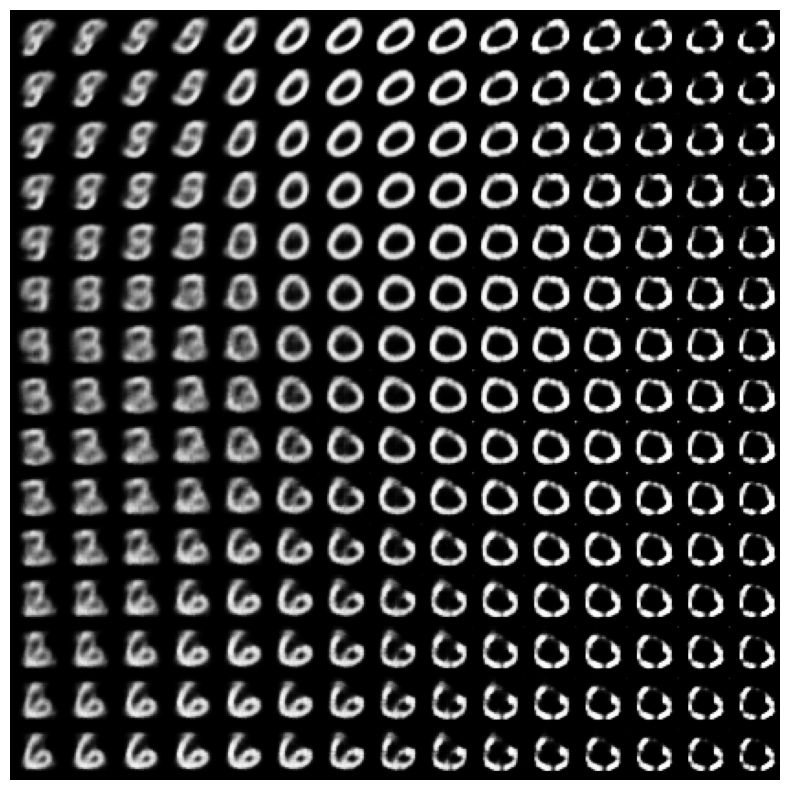

In [41]:
import matplotlib.pyplot as plt

# Создание сетки значений в латентном пространстве
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Диапазон значений для латентного пространства
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

# Генерация изображений
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])  # Создаём случайный латентный вектор
        x_decoded = decoder.predict(z_sample)  # Декодируем в изображение
        digit = x_decoded[0].reshape(digit_size, digit_size)  # Преобразуем в изображение 28x28
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit  # Добавляем в сетку

# Визуализация
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


Визуализация латентного пространства

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 280000.

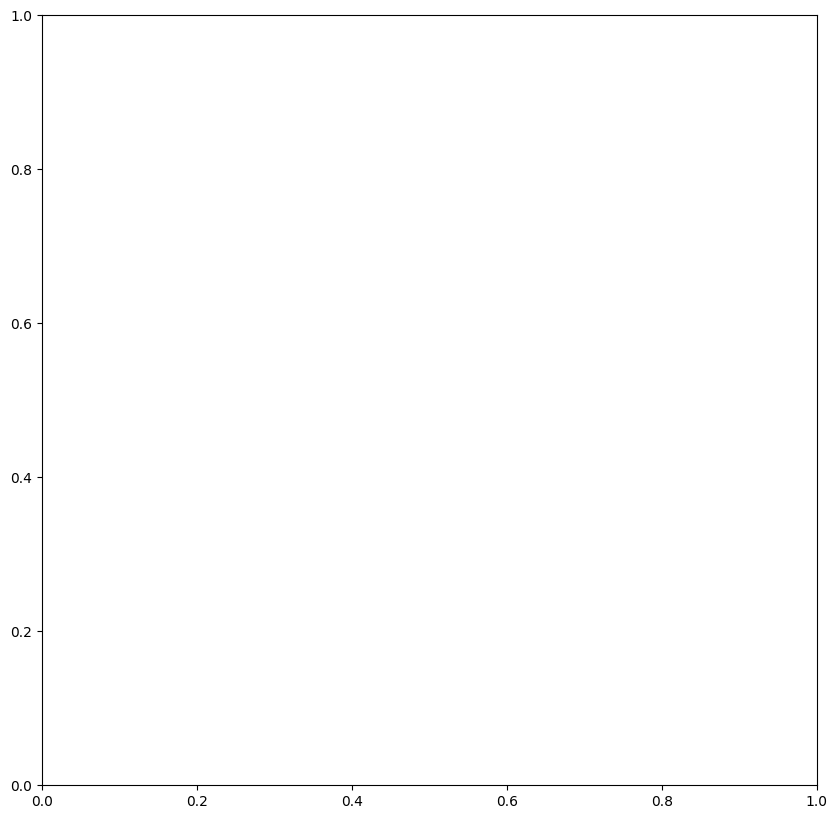

In [40]:
encoder = Model(inputs, z_mean)  # Создаём модель для кодирования в латентное пространство
z_test = encoder.predict(x_test, batch_size=128)  # Получаем латентные представления тестовых данных

# Визуализация
plt.figure(figsize=(10, 10))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='viridis')  # Раскрашиваем по классам
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()